# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Second modification of quantile objective function

<br></font>
</div>

# Import modules

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
from sklearn.base import clone
#standard
import numpy as np
np.random.seed(1) #fix seed for notebook
import pandas as pd
import scipy
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

rcParams['figure.figsize'] = 16, 8
rcParams['font.size'] = 20

In [2]:
# the mean_pinball_loss was available only in the dev version
import sklearn
sklearn.__version__

'1.0.dev0'

# Check packages version

In [ ]:
import numpy,pandas,scipy,sklearn
%load_ext watermark
%watermark -p numpy,scipy,pandas,sklearn

# General inputs

In [3]:
# Confidence Level
CL = 0.90
print("Confidence level is set to: ", CL*100,"[%]")
alphaUpper = CL + (1 - CL)/2
alphaLower= (1 - CL)/2
print("Upper percentile is set to: %.1f" %(alphaUpper*100), "[%]")
print("Lower percentile is set to: %.1f" %(alphaLower*100), "[%]")

Confidence level is set to:  90.0 [%]
Upper percentile is set to: 95.0 [%]
Lower percentile is set to: 5.0 [%]


# Create a test function & dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- To make the problem interesting, we generate observations of the target y as the sum of a deterministic term computed by the function f and a random noise term that follows a centered log-normal. 
- To make this even more interesting we consider the case where the amplitude of the noise depends on the input variable x (heteroscedastic noise).
- The lognormal distribution is non-symmetric and long tailed: observing large outliers is likely but it is impossible to observe small outliers.    

<br></font>
</div>

In [4]:
np.random.seed(1)
f = lambda u: u*np.sin(u)

#  First the noiseless case
X_train = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X_train = X_train.astype(np.float32)

# Observations
y_train = f(X_train).ravel()
dy = 1.5 + 1.0 * np.random.random(y_train.shape)
noise = np.random.normal(0, dy)
y_train += noise
y_train = y_train.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
X_test = np.atleast_2d(np.linspace(0, 10.0, 1000)).T
X_test = X_test.astype(np.float32)
y_test = f(X_test).ravel()


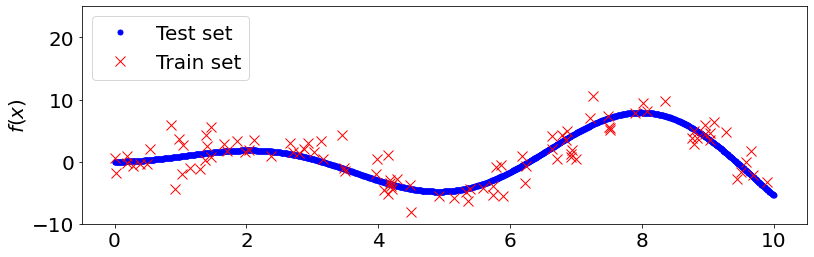

In [5]:
rcParams['figure.figsize'] = 13, 4
fig = plt.figure()
#plt.plot(xx, f(xx), 'g-', lw =1, label = r'$f(x) = x\,\sin(x)$')
plt.plot(X_test, y_test, 'b.', markersize = 10, label = 'Test set')
plt.plot(X_train, y_train, 'rx', markersize = 10, lw = 1, label = 'Train set')

plt.ylabel('$f(x)$')
plt.ylim(-10, 25)
plt.legend(loc='upper left')
plt.show()

# Custom made objective function

<div class="alert alert-block alert-info">
<font color=black><br>

- Close to the origin, we use a smoothed version of the Gradient and Hessian. This is done via **delta = quant_delta**
- Far from the origin, randomization has been added to force a random split of the partition.
- there **3** hyperparameters: delta, tau and s.

<br></font>
</div>

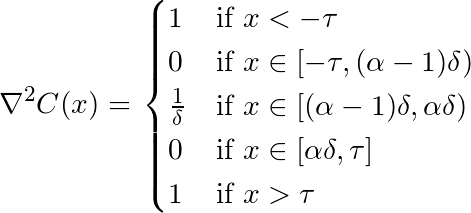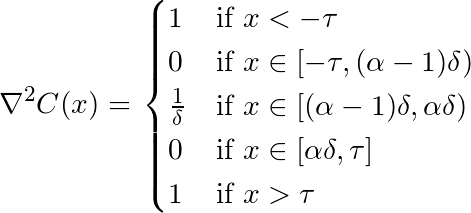

In [6]:
class XGBQuantile(XGBRegressor):
    def __init__(self, quant_alpha=0.95, quant_delta=1.0, quant_thres=1.0, quant_var=1.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=1, nthread=None, objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var

        super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                         colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
                         max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
                         n_jobs=n_jobs, nthread=nthread, objective=objective, random_state=random_state,
                         reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
                         silent=silent, subsample=subsample)

        self.test = None

    def fit(self, X, y):
        super().set_params(objective=partial(XGBQuantile.quantile_loss, alpha=self.quant_alpha,
                                             delta=self.quant_delta, threshold=self.quant_thres, var=self.quant_var))
        super().fit(X, y)
        return self

    def predict(self, X):
        return super().predict(X)

    def score(self, X, y):
        y_pred = super().predict(X)
        score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
        score = 1./score
        return score

    @staticmethod
    def quantile_loss(y_true, y_pred, alpha, delta, threshold, var):
        x = y_true - y_pred
        grad = (x < (alpha-1.0)*delta)*(1.0-alpha) - ((x >= (alpha-1.0)
                                                       * delta) & (x < alpha*delta))*x/delta-alpha*(x > alpha*delta)
        hess = ((x >= (alpha-1.0)*delta) & (x < alpha*delta))/delta

        grad = (np.abs(x) < threshold)*grad - (np.abs(x) >= threshold) * \
            (2*np.random.randint(2, size=len(y_true)) - 1.0)*var
        hess = (np.abs(x) < threshold)*hess + (np.abs(x) >= threshold)
        return grad, hess

    @staticmethod
    def original_quantile_loss(y_true, y_pred, alpha, delta):
        x = y_true - y_pred
        # print(delta)
        grad = (x < (alpha-1.0)*delta)*(1.0-alpha)-((x >= (alpha-1.0)
                                                     * delta) & (x < alpha*delta))*x/delta-alpha*(x > alpha*delta)
        hess = ((x >= (alpha-1.0)*delta) & (x < alpha*delta))/delta
        return grad, hess

    @staticmethod
    def quantile_score(y_true, y_pred, alpha):
        score = XGBQuantile.quantile_cost(x=y_true-y_pred, alpha=alpha)
        score = np.sum(score)
        return score

    @staticmethod
    def quantile_cost(x, alpha):
        return (alpha-1.0)*x*(x < 0)+alpha*x*(x >= 0)

    @staticmethod
    def get_split_gain(gradient, hessian, l=1):
        split_gain = list()
        for i in range(gradient.shape[0]):
            split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(
                gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l))

        return np.array(split_gain)

# Classical vs. XGBoost quantile function

<div class="alert alert-block alert-info">
<font color=black><br>

- XGBoost needds both gradient and hessian. However the later is costant do it does not bring any new information in response to a change in variabless
- **ATTENTION** I am not sure what delta is!
- The quantile can be found via the following optimisation problem:

$$C(x) = \left\{\begin{array}{cc}(\alpha-1)|x-q| & \mbox{if }x<q \\ \alpha|x-q| & \mbox{if }x\geq q \end{array}\right. $$

<br></font>
</div>

Text(0.5, 1.0, 'Hessian')

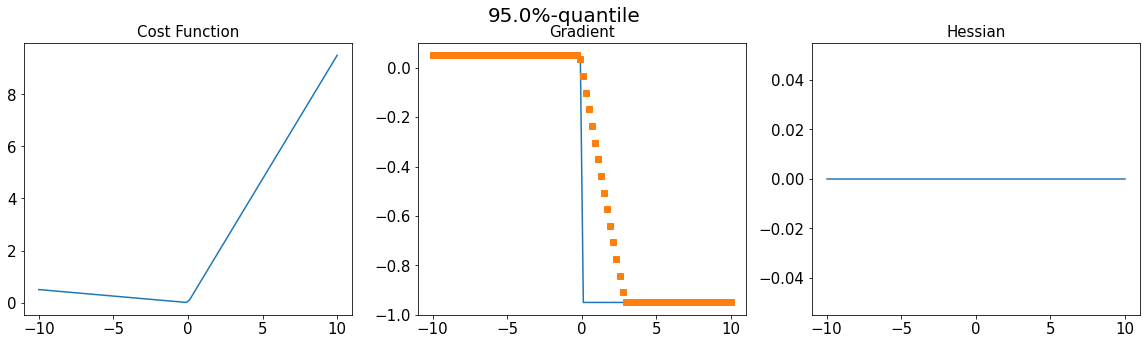

In [18]:
alpha = 0.95 
x = np.linspace(-10.,10.,100)
cost = XGBQuantile.quantile_cost(x, alpha)

fig = plt.figure(figsize=(20,5))

plt.suptitle('{alpha:0.1%}-quantile'.format(alpha=alpha),size=20)
plt.subplot(1,3,1)
plt.plot(x,cost)
plt.title('Cost Function',size=15)

grad,hess = XGBQuantile.original_quantile_loss(x, np.zeros(len(x)), alpha=alpha, delta=0.01)
grad1,hess1 = XGBQuantile.original_quantile_loss(x, np.zeros(len(x)), alpha=alpha, delta=3)

plt.subplot(1,3,2)
plt.plot(x,grad)
plt.plot(x,grad1, "s")
plt.title('Gradient',size=15)

plt.subplot(1,3,3)
plt.plot(x,hess)
plt.title('Hessian',size=15)

<div class="alert alert-block alert-info">
<font color=black><br>

- XGBoost attempts to build a new tree at every iteration by improving from the other trees.
- On constructing the new tree, the algorithm spreads data over different nodes of the tree.  
- Let us say, we have a partition of data within a node. This node is only split if it decreases the cost function. The split condition is given below:

$$\mathcal{L}_{\mbox{ split}} = \frac{\left(\sum\limits_{i \in I_L}g_j \right)^2}{\sum\limits_{i \in I_L}h_j+\lambda}+\frac{\left(\sum\limits_{i \in I_R}g_j\right)^2}{\sum\limits_{i \in I_R}h_j+\lambda}-\frac{\left(\sum\limits_{i \in I}g_j\right)^2}{\sum\limits_{i \in I}h_j+\lambda}~~~~\mbox{for } I_{L} \cup I_{R} = I $$


- Feel free to shift around the values around in the partition by varying  **partition_min** and **partition_max**.
- Recall that points near **origin** mean that for these points the algorithms is already estimating very well the quantile. 
- As we rarely have such an accurate estimate before boosting, each datapoint are **concentrated far from the origin**. 
- Due to the lack of variation in the gradient and hessian in these regions, the split_gain will generally be zero. 
- Therefore, the node of the tree will not be split. 
- **This is why**, XGBoost does not work with cost function with constant gradients/hessians.

<br></font>
</div>

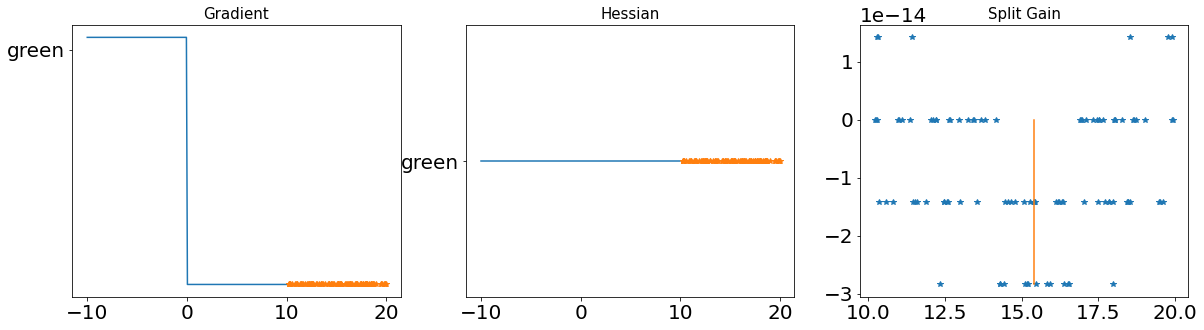

In [8]:
x_min = -10.
x_max = 10.

alpha = 0.95 
partition_min = 10
partition_max = 20 
data_volume = 100  

VOLUME = data_volume*2
x = np.linspace(x_min,x_max,VOLUME)

x_sample = np.sort((partition_max-partition_min)*np.random.rand(VOLUME//2,)+ partition_min)
grad,hess = XGBQuantile.original_quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=0.01)

grad_sample,hess_sample = XGBQuantile.original_quantile_loss(x_sample, 
                                      np.zeros(len(x_sample)),
                                      alpha=alpha,
                                      delta=0.01)
split_gain = XGBQuantile.get_split_gain(grad_sample,hess_sample,l=1.0)

fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,grad)
plt.plot(x_sample,grad_sample,'*','green')
plt.title('Gradient',size=15)

plt.subplot(1,3,2)
plt.plot(x,hess)
plt.title('Hessian',size=15)
plt.plot(x_sample,hess_sample,'*','green')

plt.subplot(1,3,3)
plt.title('Split Gain',size=15)
plt.plot(x_sample,split_gain,'*')
plt.plot(np.ones((VOLUME//2,))*np.median(x_sample),np.linspace(np.min(split_gain),0,VOLUME//2))

<div class="alert alert-block alert-info">
<font color=black><br>

- What can we do about it?
- Ideally, we wish the following:

    - If points are far from the origin,i.e. the difference between the true quantile and its estimate, we wish to reshuffle our estimate.  We can force a randomsplit by randomizing the gradient and making the hessian constant.
    - If points close enough to the true quantile, we wish to bring them closer by smoothing a small region around the origin

- We can achieve this by some hyperparameters.
    
<br></font>
</div>

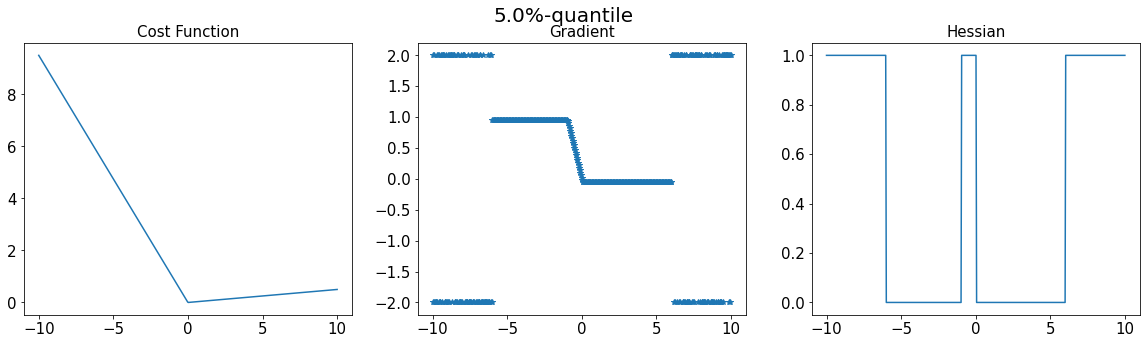

In [31]:
alpha = 0.05 
threshold = 6
delta = 1 
variance = 2. 
x = np.linspace(-10.,10.,500)

cost = XGBQuantile.quantile_cost(x, alpha)
'''
Plots of gradient, hessian and cost function for quantile regression
'''
fig = plt.figure(figsize=(20,5))

plt.suptitle('{alpha:0.1%}-quantile'.format(alpha=alpha),size=20)
plt.subplot(1,3,1)
plt.plot(x,cost)
_ = plt.title('Cost Function',size=15)

grad,hess = XGBQuantile.quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=delta,
                                      threshold=threshold,
                                      var=variance)

plt.subplot(1,3,2)
plt.plot(x,grad,'*')
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,3)
plt.plot(x,hess)
_ = plt.title('Hessian',size=15)

# Sklearn Quantile Gradient Boosting versus XGBoost with Custom Loss

In [10]:
regressor = GradientBoostingRegressor(n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
y_pred = regressor.fit(X_train,y_train).predict(X_test)

regressor.set_params(loss='quantile', alpha= alphaLower)
regressor.fit(X_train,y_train)
y_lower = regressor.predict(X_test)

regressor.set_params(loss='quantile', alpha = alphaUpper)
regressor.fit(X_train,y_train)
y_upper = regressor.predict(X_test)




regressor = XGBRegressor(n_estimators=250,max_depth=3,reg_alpha=5, reg_lambda=1,gamma=0.5)
y_pred_m = regressor.fit(X_train,y_train).predict(X_test)

regressor.set_params(quant_alpha = alphaLower,quant_delta=1.0,quant_thres=5.0,quant_var = 4.2)
regressor = XGBQuantile(n_estimators=100,max_depth = 3, reg_alpha =5.0,gamma = 0.5,reg_lambda =1.0 )     
regressor.fit(X_train,y_train)
y_lower_m = regressor.predict(X_test)

regressor.set_params(quant_alpha = alphaUpper,quant_delta=1.0,quant_thres=6.0,quant_var = 3.2)
regressor.fit(X_train,y_train)
y_upper_m = regressor.predict(X_test)


[13:41:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Post-processing

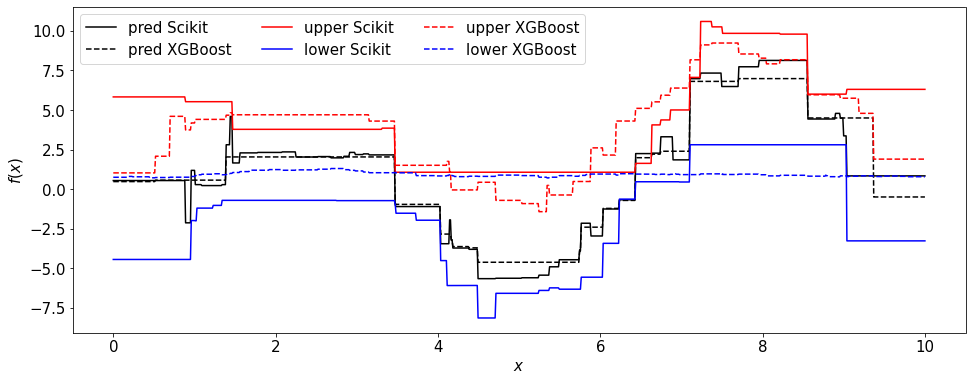

In [11]:
xx = np.atleast_2d(np.linspace(0, 10, len(X_test))).T
rcParams['font.size'] = 15
rcParams['figure.figsize'] = 16, 6

fig = plt.figure()
#plt.plot(X_test, y_test, 'ks', markersize=3, label = 'Test')
plt.plot(X_test, y_pred, 'k-', markersize=5, label = 'pred Scikit')
plt.plot(X_test, y_pred_m, 'k--', markersize=5, label = 'pred XGBoost')

plt.plot(X_test, y_upper, "r-", label = 'upper Scikit')
plt.plot(X_test, y_lower, "b-", label = 'lower Scikit')
plt.plot(X_test, y_upper_m, "r--", label = 'upper XGBoost')
plt.plot(X_test, y_lower_m, "b--", label = 'lower XGBoost')


plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc = 'upper left', ncol = 3)
plt.show()

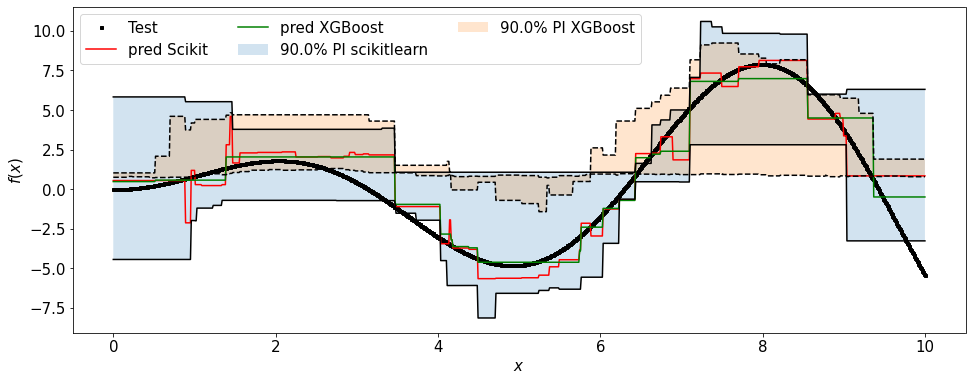

In [12]:
xx = np.atleast_2d(np.linspace(0, 10, len(X_test))).T
rcParams['font.size'] = 15
rcParams['figure.figsize'] = 16, 6

fig = plt.figure()
plt.plot(X_test, y_test, 'ks', markersize=3, label = 'Test')
plt.plot(X_test, y_pred, 'r-', markersize=5, label = 'pred Scikit')
plt.plot(X_test, y_pred_m, 'g-', markersize=5, label = 'pred XGBoost')

plt.plot(X_test, y_upper, "k-")
plt.plot(X_test, y_lower, "k-")
plt.plot(X_test, y_upper_m, "k--")
plt.plot(X_test, y_lower_m, "k--")


plt.fill_between(xx.ravel(), y_lower, y_upper, alpha = 0.2,
                 label = str(CL*100) +'% PI scikitlearn')

plt.fill_between(xx.ravel(), y_lower_m, y_upper_m, alpha = 0.2,
                 label = str(CL*100) +'% PI XGBoost')



plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left', ncol = 3)
plt.show()

# References

<div class="alert alert-block alert-info">
<font color=black><br>

**Reference [article]:** https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b<br>
**Reference [code]:** https://colab.research.google.com/drive/1KlRkrLi7JmVpprL94vN96lZU-HyFNkTq?usp=sharing#scrollTo=-aNl8rZp1CY9<br>

<br></font>
</div>

# Conclusion

<div class="alert alert-block alert-danger">
<font color=black><br>

- When the quantile loss function, you need to calibrate the regressor with the appropriate metrics.
- Even in the case of **calibrated** regressor, it is seems that it is dificult to converge this objective function.
- MSE is **no-longer** valid as a metric when data are not normally dsitributed.
- I have some doubt as if this is better than scikit learn. It most definetly offer a way to make in XGBoost.

<br></font>
</div>